<a href="https://colab.research.google.com/github/MBrandao07/People_Analytics_CRM/blob/main/Codigos/People_Analytics_CRM_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projeto CRM**

# 1- Entendimento do Negócio

A RetaiX emprega cerca de 4000 funcionários. No entanto, todos os anos, cerca de 15% de seus funcionários deixam a empresa e precisam ser substituídos por novos funcionários que estão disponíveis no mercado. A gestão acredita que esse nível de rotatividade (funcionários saindo, seja por vontade própria ou porque foram demitidos) é ruim para a empresa, pelos seguintes motivos:

* Dificuldade no cumprimento dos prazos, resultando em perda de reputação entre consumidores e parceiros;

* Um departamento considerável precisa ser mantido para fins de recrutamento de novos talentos;

* Na maioria das vezes, os novos funcionários precisam ser treinados para o trabalho e/ou precisam de tempo para se ambientarem à empresa.

Por outro lado, a RetailX também percebeu que poderia melhorar o relacionamento com os clientes, por meio do entendimento do comportamento de compra deles. A empresa possui dados de campanhas, compras, cadastro e até da renda de cada cliente.

Diante deste cenário a empresa decidiu investir em dois projetos:

* Projeto de RH;

* **Projeto de CRM**.

Neste momento, focaremos no **Projeto de CRM** com os seguintes objetivos:

* Encontrar personas no grupo de clientes para identificar padrões de comportamento;

* Analisar cada persona e verificar se existem ações que podem ser feitas para melhorar a relação com os clientes;

* Gerar um relatório com as conclusões para que o gestor do CRM possa tomar as devidas providências para que a empresa aumente o faturamento, reduze o custos com campanhas e melhore o relacionamento com os clientes.

# 2- Entendimento dos dados

In [1]:
# importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage
import time
from datetime import datetime

In [2]:
# conectando ao drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2.1 Funções

In [3]:
# Função para gerar os metadados do dataframe
def generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='percent_nulos',ascending=False)
    metadata = metadata.reset_index(drop=True)

    return metadata


# Função para plotar boxplots para variáveis numéricas
def boxplots_var_num(dataframe):
    """
    Plota boxplots para todas as variáveis numéricas do dataframe fornecido em um painel com 3 gráficos por linha.

    :param dataframe: DataFrame para o qual os boxplots serão gerados.
    """
    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Define o número de linhas com base no número de colunas numéricas
    nrows = len(numeric_columns) // 3 + (len(numeric_columns) % 3 > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(12, nrows * 4))

    # Ajusta o layout
    plt.tight_layout(pad=4)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota boxplots para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        sns.boxplot(data=dataframe[column], ax=axes[i//3, i%3], color="skyblue")
        axes[i//3, i%3].set_title(f'{column}', fontdict={'fontsize': 11, 'fontweight': 'bold'})
        axes[i//3, i%3].set_ylabel('')

    # Remove gráficos vazios (se houver)
    for j in range(i+1, nrows*3):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - Boxplots", fontsize=16, fontweight='bold', y=1.00)



# Função para plotar histogramas com KDE para variáveis numéricas
def histograms_var_num(dataframe):
    """
    Plota histogramas corrigidos com a curva KDE (Kernel Density Estimation) para todas as variáveis numéricas
    do dataframe fornecido em um painel com 3 gráficos por linha.

    :param dataframe: DataFrame para o qual os histogramas serão gerados.
    """
    # Seleciona apenas colunas numéricas
    numeric_columns = dataframe.select_dtypes(include=['float64', 'int64']).columns

    # Define o número de linhas com base no número de colunas numéricas
    nrows = len(numeric_columns) // 3 + (len(numeric_columns) % 3 > 0)

    # Inicializa o painel de gráficos
    fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(12, nrows * 4))

    # Ajusta o layout
    plt.tight_layout(pad=4)

    # Configura estilo e paleta de cores
    sns.set_style("whitegrid")

    # Plota histogramas com KDE para cada coluna numérica
    for i, column in enumerate(numeric_columns):
        sns.histplot(data=dataframe[column], ax=axes[i//3, i%3], color="skyblue", bins=30, kde=True)
        axes[i//3, i%3].set_title(f'{column}', fontdict={'fontsize': 11, 'fontweight': 'bold'})
        axes[i//3, i%3].set_ylabel('Frequência')
        axes[i//3, i%3].tick_params(axis='both', which='major', labelsize=12)

    # Remove gráficos vazios (se houver)
    for j in range(i+1, nrows*3):
        fig.delaxes(axes.flatten()[j])

    # Adiciona título principal
    fig.suptitle("Análise descritiva - Histograma com KDE", fontsize=16, fontweight='bold', y=1.00)



# Função para plotar gráficos de barras para as variáveis categóricas
def plot_cat_counts(dataframe, cutoff=10):
    """
    Plota gráficos de barras (não empilhados) para variáveis categóricas,
    mostrando a contagem de cada categoria, com os valores no topo de cada barra.

    :param dataframe: DataFrame contendo variáveis categóricas.
    :param cutoff: Máximo de categorias únicas permitido por variável para ser incluída no plot.
    """
    # Seleciona colunas categóricas
    categorical_columns = dataframe.select_dtypes(include=['object', 'category']).columns

    # Filtra colunas com base no número de categorias únicas
    categorical_columns_filtered = [col for col in categorical_columns if dataframe[col].nunique() <= cutoff]

    # Define número de linhas e colunas para subplots
    n_rows = len(categorical_columns_filtered) // 3 + (len(categorical_columns_filtered) % 3 > 0)
    n_cols = min(len(categorical_columns_filtered), 3)

    # Cria subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5))
    axes = axes.flatten() if len(categorical_columns_filtered) > 1 else [axes]

    plt.tight_layout(pad=4)

    for i, column in enumerate(categorical_columns_filtered):
        # Contagem das categorias
        count_series = dataframe[column].value_counts()

        # Plot
        ax = axes[i]
        bars = ax.bar(count_series.index, count_series.values)

        # Título e labels
        ax.set_title(column, fontsize=14)
        ax.set_ylabel('Contagem')
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_xticklabels(count_series.index, rotation=45, ha='right')

        # Adiciona os valores no topo das barras
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=10
            )

    # Remove subplots vazios
    for j in range(len(categorical_columns_filtered), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Contagem das Variáveis Categóricas", fontsize=16, fontweight='bold', y=1.02)
    plt.subplots_adjust(wspace=0.5, hspace=0.7)
    plt.show()




# Função para plotar gráficos de barras para variáveis categóricas em relação ao target (stacked, proporção)
def plot_cat_vs_target_percentage(dataframe, target_column, cutoff=10):
    """
    Plota gráficos de barras empilhadas 100% para analisar as variáveis categóricas em relação ao target,
    limitando o número de variáveis de acordo com um valor de cutoff.

    :param dataframe: DataFrame contendo as variáveis categóricas e a coluna target.
    :param target_column: Nome da coluna target.
    :param cutoff: Valor de cutoff para limitar o número de variáveis categóricas plotadas (padrão é 10).
    """
    # Seleciona apenas colunas categóricas
    categorical_columns = dataframe.select_dtypes(include=['object', 'category']).columns

    # Filtra as colunas com base no cutoff
    categorical_columns_filtered = [col for col in categorical_columns if dataframe[col].nunique() <= cutoff]

    # Define o número de linhas e colunas para os subplots
    n_rows = len(categorical_columns_filtered) // 3 + (len(categorical_columns_filtered) % 3 > 0)
    n_cols = min(len(categorical_columns_filtered), 3)

    # Cria subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 5))

    # Ajusta o layout
    plt.tight_layout(pad=4)

    # Loop pelas colunas categóricas filtradas
    for i, column in enumerate(categorical_columns_filtered):
        # Calcula proporções de cada categoria para cada valor do target
        prop_df = (dataframe.groupby([column, target_column]).size() / dataframe.groupby(column).size()).unstack()

        # Plota o gráfico de barras empilhadas 100%
        ax = axes[i // n_cols, i % n_cols] if n_rows > 1 else axes[i]
        prop_df.plot(kind='bar', stacked=True, ax=ax)
        ax.set_title(column, fontsize=14)
        ax.set_ylabel('Porcentagem')
        ax.tick_params(axis='both', which='major', labelsize=12)

        # Rotaciona as labels do eixo x
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

        # Ajusta o layout do subplot
        plt.subplots_adjust(wspace=0.5, hspace=0.7)

    # Remove subplots vazios
    for j in range(len(categorical_columns_filtered), n_rows * n_cols):
        if n_rows > 1:
            fig.delaxes(axes.flatten()[j])
        else:
            fig.delaxes(axes)

    # Adiciona título principal
    fig.suptitle("Análise de Variáveis Categóricas em relação ao Target", fontsize=16, fontweight='bold', y=1.02)

## 2.2 Importando a base de dados

In [4]:
df_publico = pd.read_csv('/content/drive/MyDrive/2 - Projetos Portfolio/People Analytics/Base de dados/tb_crm_clientes.csv')
df_publico.head()

,IDCliente,AnoDeNascimento,NivelDeEducacao,EstadoCivil,RendaAnualFamiliar,QtdDeCriancasNaCasa,QtdDeAdolescentesNaCasa,DataDeInscricao,DiasDesdeUltimaCompra,GastoComVinhoNosUltimos2Anos,...,VisitasAoSiteNoUltimoMes,AceitouCampanha3,AceitouCampanha4,AceitouCampanha5,AceitouCampanha1,AceitouCampanha2,ReclamouNosUltimos2Anos,IndicadorCustoContato,IndicadorDeReceita,AceitouUltimaCampanha
0,5524,1957,Graduação,Solteiro(a),58138.0,0,0,2021-04-09,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduação,Solteiro(a),46344.0,1,1,2023-08-03,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduação,União Estável,71613.0,0,0,2022-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduação,União Estável,26646.0,1,0,2023-10-02,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,Doutorado,Casado(a),58293.0,1,0,2023-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


## 2.3 Analisando a base de dados

### 2.3.1 Analisando os metadados

In [5]:
# verificando os metadados
generate_metadata(df_publico)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,RendaAnualFamiliar,float64,24,1.07,1974
1,IDCliente,int64,0,0.00,2240
2,AnoDeNascimento,int64,0,0.00,59
3,NivelDeEducacao,object,0,0.00,5
4,EstadoCivil,object,0,0.00,8
5,QtdDeCriancasNaCasa,int64,0,0.00,3
6,QtdDeAdolescentesNaCasa,int64,0,0.00,3
7,DataDeInscricao,object,0,0.00,663
8,DiasDesdeUltimaCompra,int64,0,0.00,100
9,GastoComVinhoNosUltimos2Anos,int64,0,0.00,776


* Apenas 1 coluna possui valores nulos, tendo 1,07% de nulos;

* A coluna DataDeInscricao está como "object" mas por ser uma data ela pode ser convertida para "datetime".

### 2.3.2 Analisando as estatísticas descritivas

In [6]:
df_publico.describe()

,IDCliente,AnoDeNascimento,RendaAnualFamiliar,QtdDeCriancasNaCasa,QtdDeAdolescentesNaCasa,DiasDesdeUltimaCompra,GastoComVinhoNosUltimos2Anos,GastoComFrutasNosUltimos2Anos,GastoComCarneNosUltimos2Anos,GastoComPeixeNosUltimos2Anos,...,VisitasAoSiteNoUltimoMes,AceitouCampanha3,AceitouCampanha4,AceitouCampanha5,AceitouCampanha1,AceitouCampanha2,ReclamouNosUltimos2Anos,IndicadorCustoContato,IndicadorDeReceita,AceitouUltimaCampanha
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,...,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,...,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,...,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,...,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,...,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,...,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


* A base possui 2240 clientes, sem nenhum missing nessa variável;

* Tem clientes nascidos entre 1893 e 1996;

* A renda familiar varia desde 1.730,00 até 666.666,00;

* Os clientes possuem entre 0 e 2 crianças ou adolescentes em casa.

### 2.3.3 Analisando a taxa de aceitação geral

Primeiro vamos criar uma variável para verificar se o cliente aceitou qualquer uma das campanhas

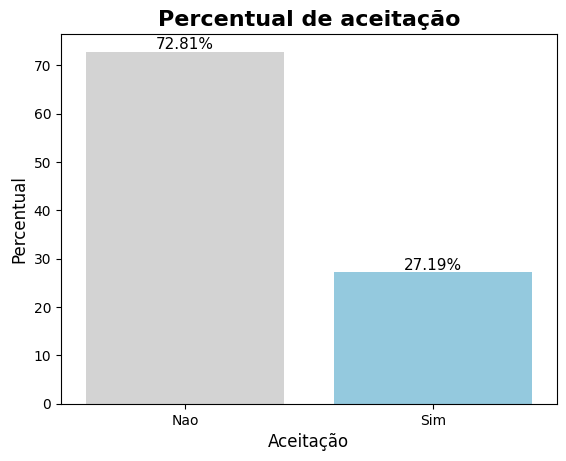

In [7]:
# criando a variável "AceitouAlgumaCampanha"
df_publico['AceitouAlgumaCampanha'] = df_publico[['AceitouCampanha1', 'AceitouCampanha2', 'AceitouCampanha3', 'AceitouCampanha4', 'AceitouCampanha5', 'AceitouUltimaCampanha']].any(axis=1).astype(int)

# contando a quantidade de pessoas que aceitaram ou não alguma campanha
aceitacao_counts = df_publico['AceitouAlgumaCampanha'].value_counts()

# Calculando os percentuais de aceitacao
percent_nao = (aceitacao_counts[0] / len(df_publico)) * 100
percent_sim = (aceitacao_counts[1] / len(df_publico)) * 100

# Criando o DataFrame total_by_aceitacao
total_por_aceitacao = pd.DataFrame({'AceitouAlgumaCampanha': ['Nao', 'Sim'], 'Percent': [percent_nao, percent_sim]})

# Definindo as cores do gráfico de barras
cores = {'Nao': 'lightgrey', 'Sim': 'skyblue'}

# Plotando o gráfico de barras com seaborn
ax = sns.barplot(x='AceitouAlgumaCampanha', y='Percent', hue='AceitouAlgumaCampanha', data=total_por_aceitacao, palette=cores, dodge=False)

# Adicionando os valores de cada barra com símbolo de porcentagem
for p in ax.patches:
    ax.annotate("{:.2f}%".format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Aceitação', fontsize=12)
plt.ylabel('Percentual', fontsize=12)
plt.title('Percentual de aceitação', fontsize=16, fontweight='bold', y=1.0)
plt.show()

* Apenas 27,19% dos clientes já aceitou pelo menos uma campanha, enquanto 72,81% não aceitou nenhuma.

### 2.3.4 Análise geral das variávels numéricas

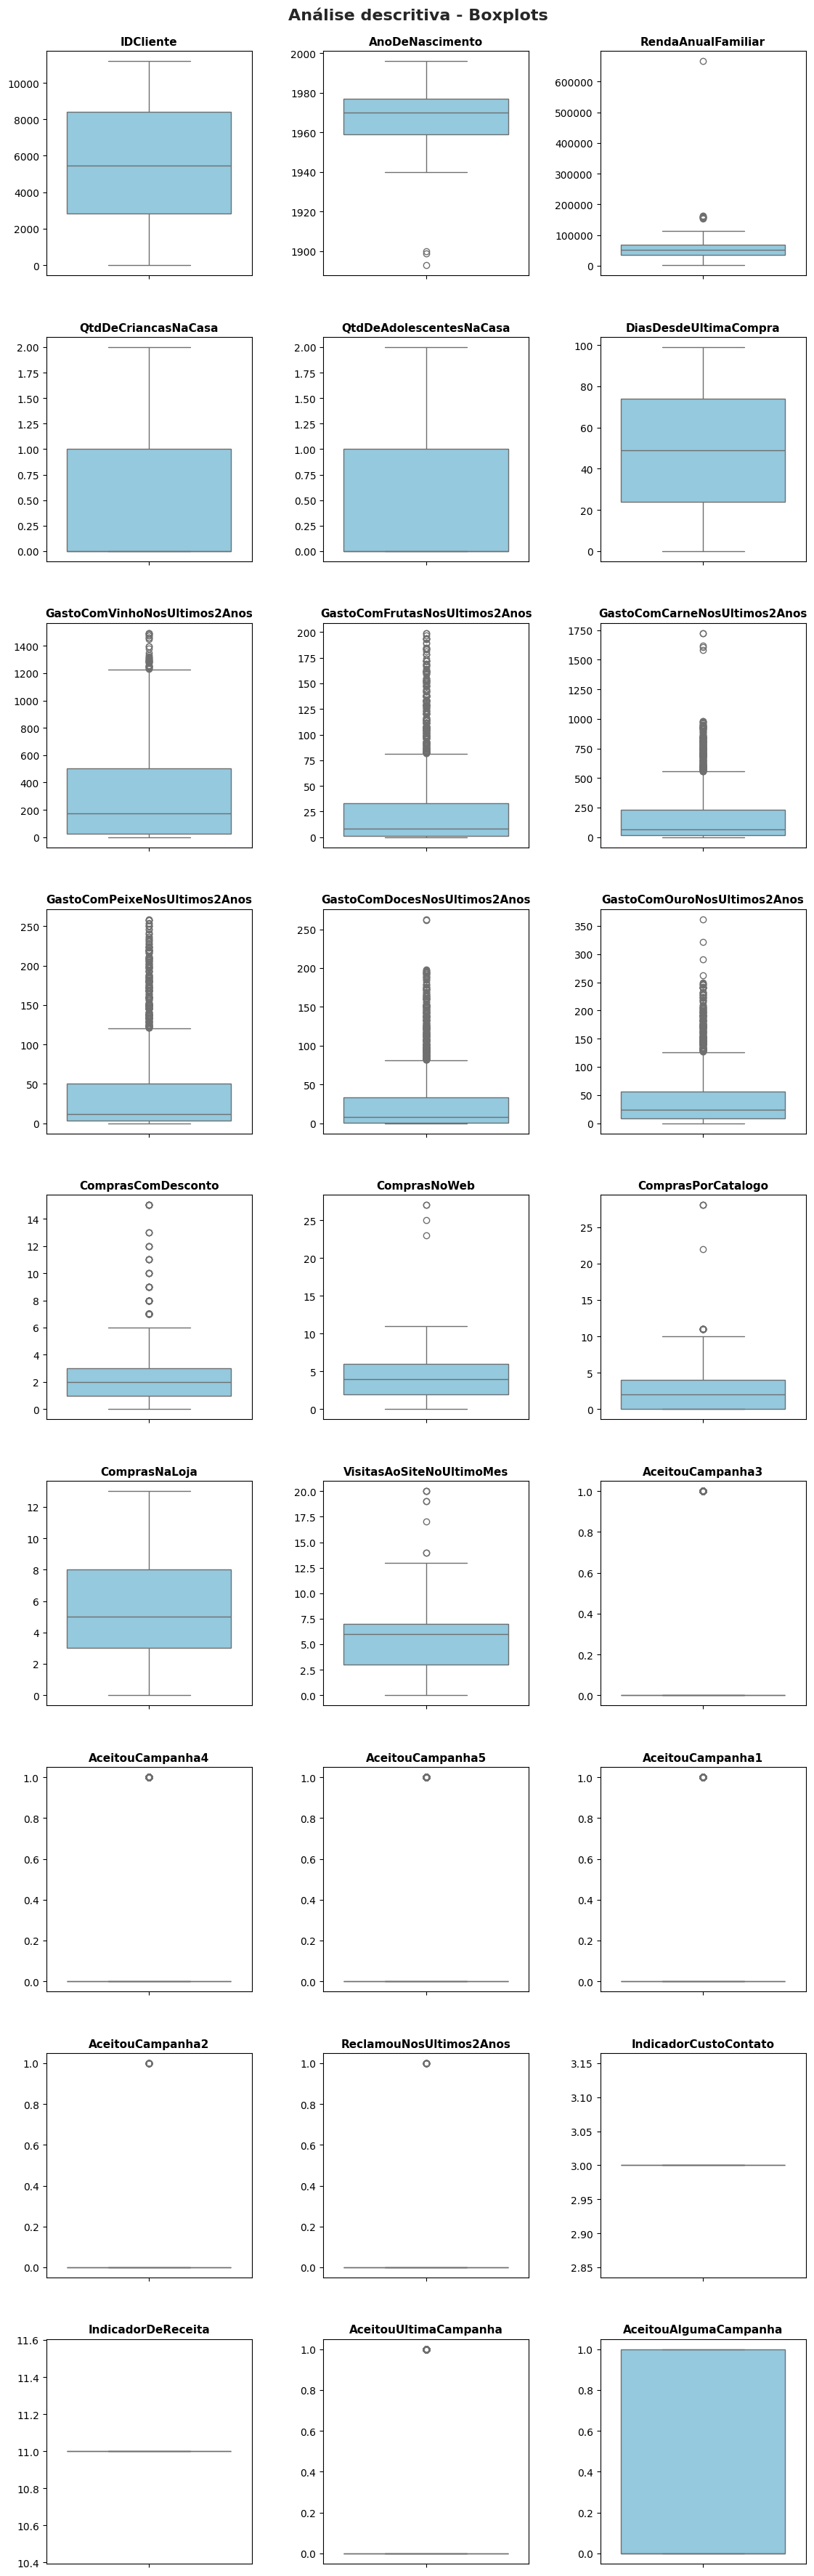

In [8]:
# verificand o boxplot das variáveis numéricas
boxplots_var_num(df_publico)

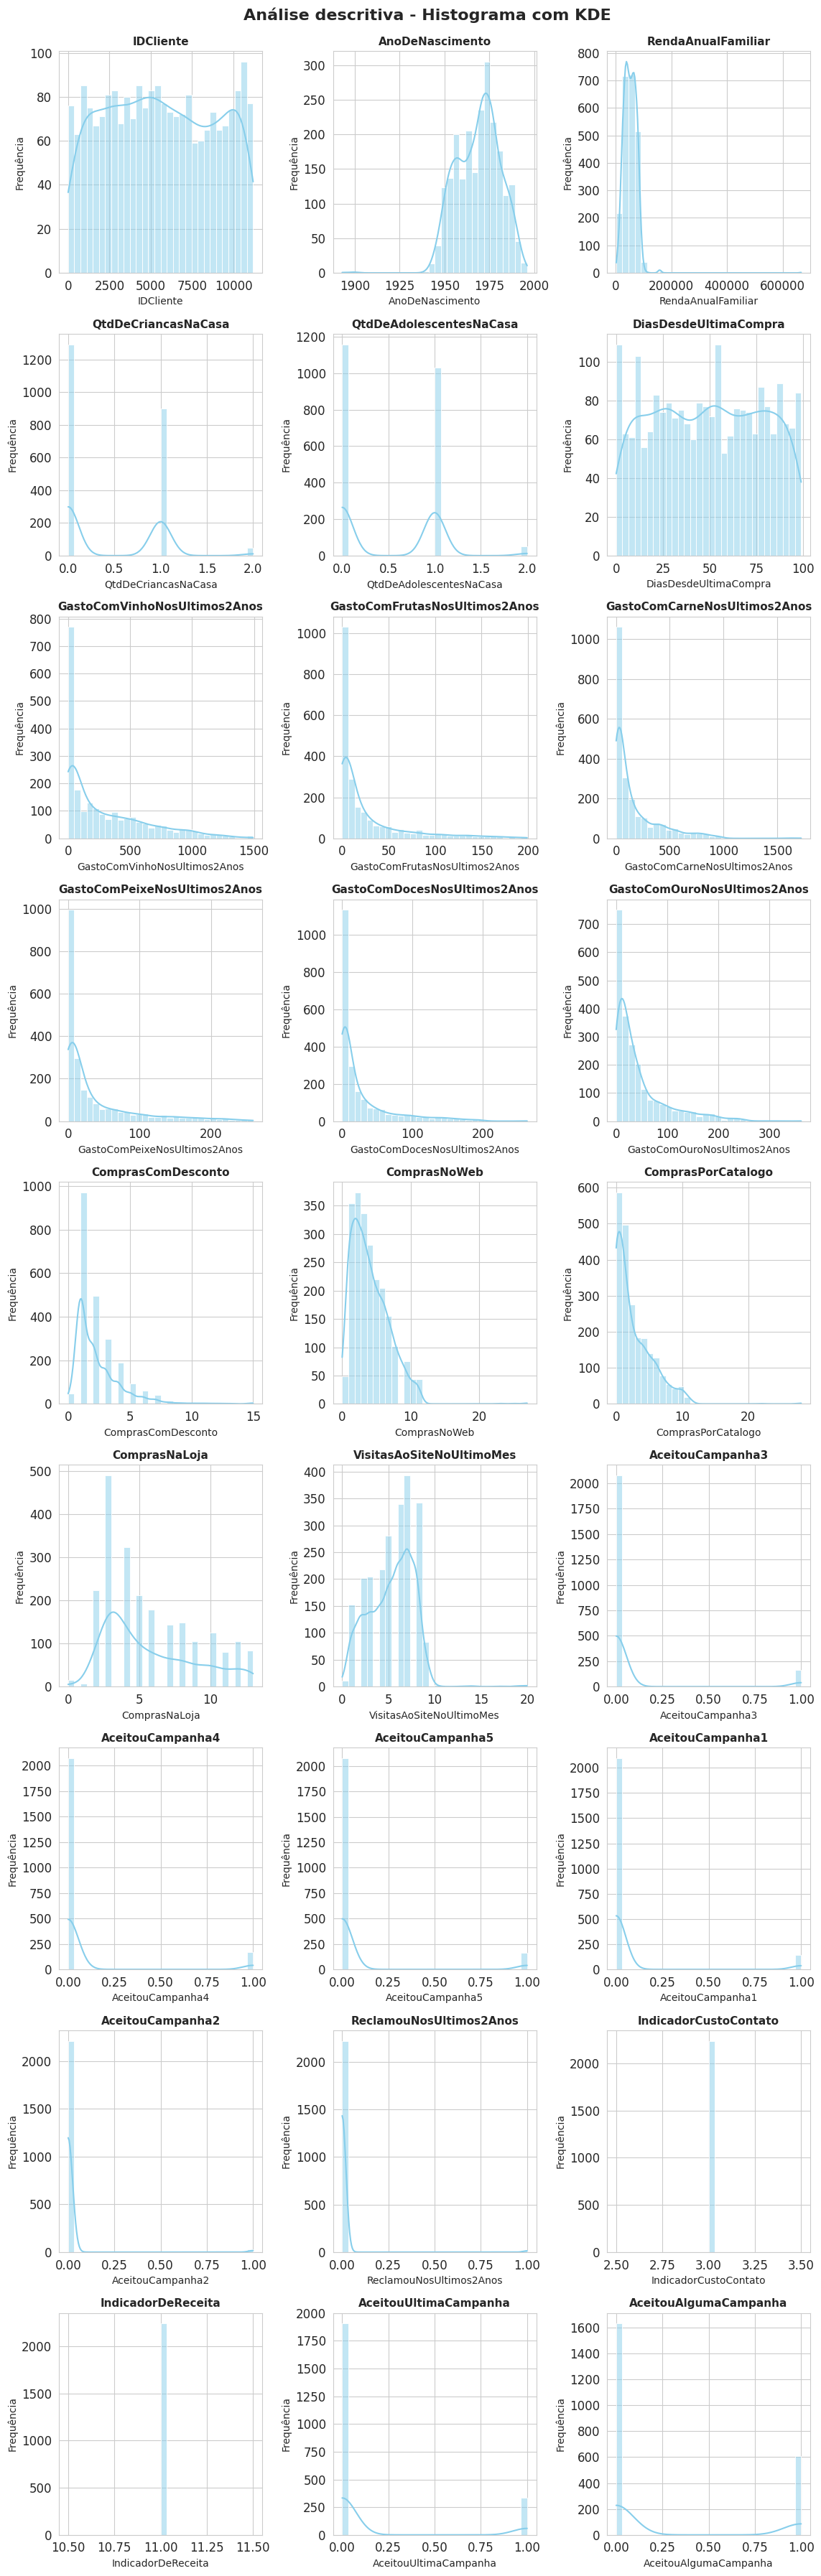

In [9]:
# verificando os histogramas das variáveis numéricas
histograms_var_num(df_publico)

* Temos algunas outliers no ano de nascimento, indicando que os clientes nasceram em torno de 1900 ou menos, porém pode ser um erro de digitação;

* A maior parte da renda anual familiar está concentrada abaixo de 150.000, porém temos algums outliers acima disso;

* Todos os clientes possuem entre 0 e 2 crianças ou adolescentes em casa;

* Os gastos de todas as categorias tem diversos outliers;

* Parece que os clientes tendem a fazer mais compras na loja do que no site;

* Poucos clientes aceitaram alguma das campanhas.

### 2.3.4 Análise geral das variávels categóricas

/tmp/ipython-input-341996416.py:137: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(count_series.index, rotation=45, ha='right')
/tmp/ipython-input-341996416.py:137: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(count_series.index, rotation=45, ha='right')


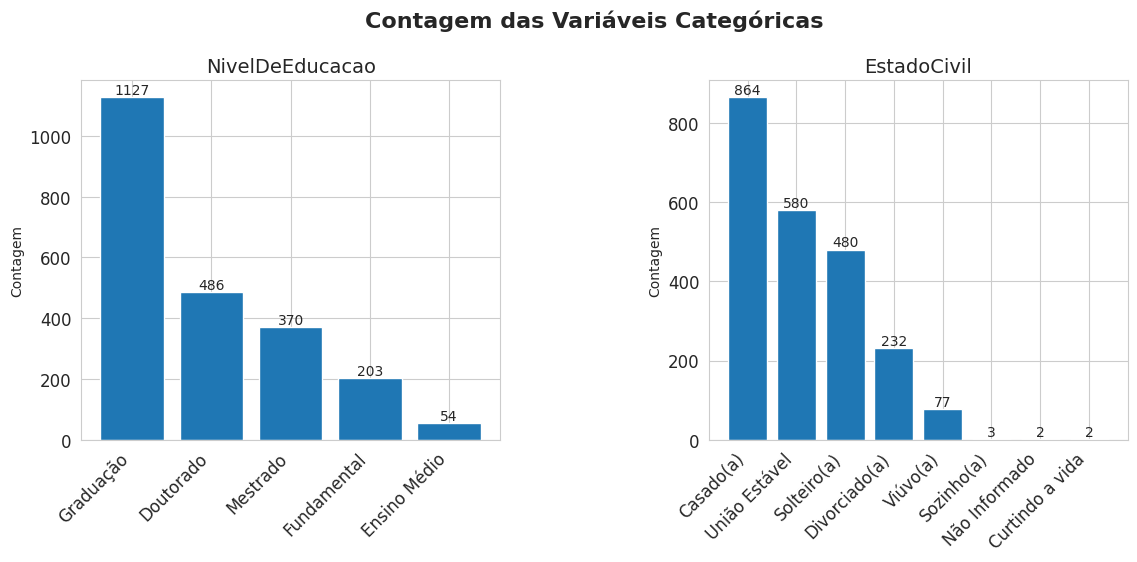

In [10]:
plot_cat_counts(df_publico, cutoff=10)

* A maior parte dos clientes possui graduação, seguida de doutorado e mestrado;

* Grande parte da base é casada ou possui união estável.

## 2.4 Análise individual das variáveis

### 2.4.1 Renda Anual

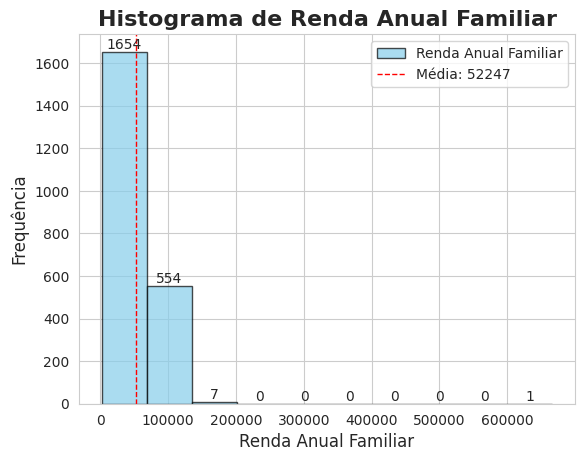

In [11]:
# Plotando o histograma das idades
hist, bins, _ = plt.hist(df_publico['RendaAnualFamiliar'], bins=10, color='skyblue', edgecolor='black', alpha=0.7, label='Renda Anual Familiar')

# Calculando a média das idades
media_renda = df_publico['RendaAnualFamiliar'].mean()

# Adicionando a linha vertical para a média
plt.axvline(media_renda, color='red', linestyle='dashed', linewidth=1)
plt.legend(['Renda Anual Familiar', 'Média: {:.0f}'.format(media_renda)], loc='upper right')

# Adicionando os valores da frequência em cada barra
for i in range(len(hist)):
    plt.text(bins[i] + (bins[i+1] - bins[i]) / 2, hist[i], str(int(hist[i])), ha='center', va='bottom')

# Configurando os rótulos e título
plt.xlabel('Renda Anual Familiar', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.title('Histograma de Renda Anual Familiar', fontsize=16, fontweight='bold')

# Mostrando o gráfico
plt.show()

### 2.4.2 Renda anual X Target

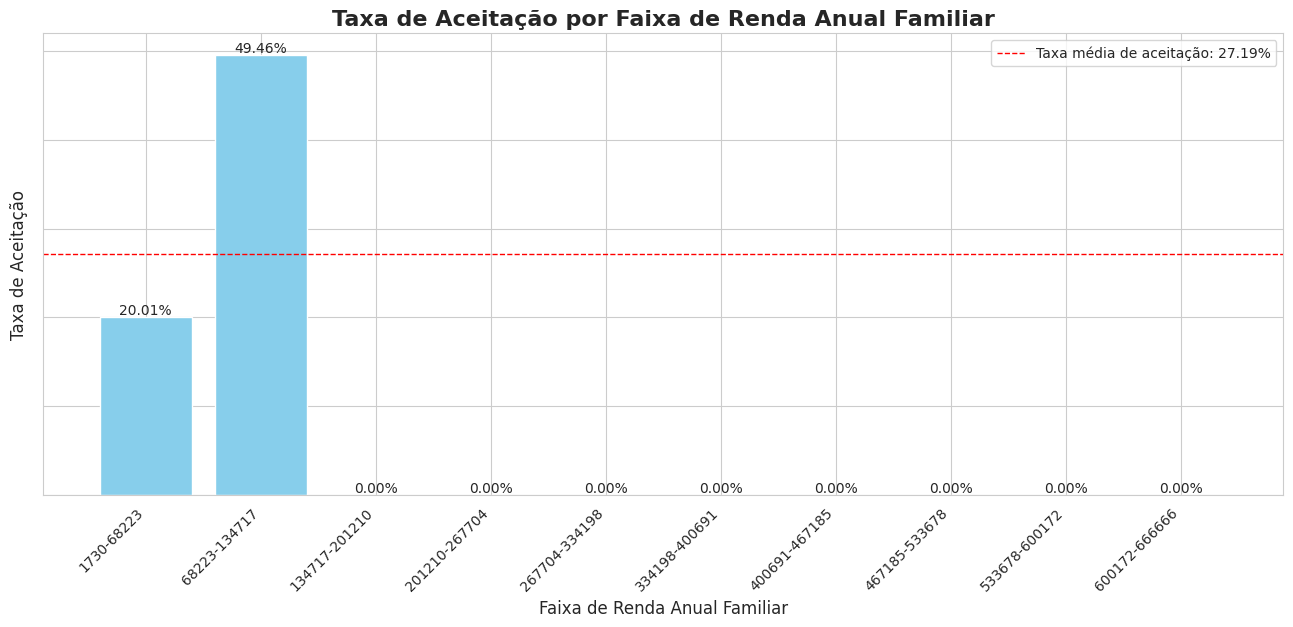

In [12]:
# criando as faixas
taxa_aceitacao_por_faixa = []
for i in range(len(bins)-1):
    faixa_inferior = bins[i]
    faixa_superior = bins[i+1]
    taxa_aceitacao = df_publico[(df_publico['RendaAnualFamiliar'] >= faixa_inferior) & (df_publico['RendaAnualFamiliar'] <= faixa_superior)]['AceitouAlgumaCampanha'].value_counts(normalize=True).get(1, 0)
    taxa_aceitacao_por_faixa.append(taxa_aceitacao)

# Calculando a média da variável de aceitacao
taxa_media_aceitacao = df_publico['AceitouAlgumaCampanha'].value_counts(normalize=True).get(1, 0)

# Plotando o gráfico de barras
plt.figure(figsize=(16,6))
plt.bar(range(len(bins)-1), taxa_aceitacao_por_faixa, color='skyblue')

# Adicionando os valores das taxas de aceitacao nas barras
for i, taxa in enumerate(taxa_aceitacao_por_faixa):
    plt.text(i, taxa, '{:.2f}%'.format(taxa * 100), ha='center', va='bottom', fontsize=10)

# Adicionando uma linha indicando a média da variável de aceitacao
plt.axhline(taxa_media_aceitacao, color='red', linestyle='dashed', linewidth=1, label='Taxa média de aceitação: {:.2f}%'.format(taxa_media_aceitacao * 100))

# Adicionando as faixas de idade no eixo x
plt.xticks(range(len(bins)-1), ['{}-{}'.format(int(faixa_inf), int(faixa_sup)) for faixa_inf, faixa_sup in zip(bins[:-1], bins[1:])], rotation=45, ha='right')

plt.gca().axes.yaxis.set_ticklabels([])

# Adicionando rótulos e título
plt.xlabel('Faixa de Renda Anual Familiar', fontsize=12)
plt.ylabel('Taxa de Aceitação', fontsize=12)
plt.title('Taxa de Aceitação por Faixa de Renda Anual Familiar', fontsize=16, fontweight='bold')

# Adicionando a legenda
plt.legend()

# Mostrando o gráfico
plt.show()

* A grande maioria da base ganha até 150.000;

* O nível de aceitação de clientes que ganham até 134.717 é consideravelmente mais alto que a média, então provavelmente é interessante oferecer campanhas mais direcionadas a essas pessoas;

* Temos muito poucas pessoas que ganham mais do que 134.717, então o nível de aceitação não deve ser considerado.



### 2.4.3 Nível de educação

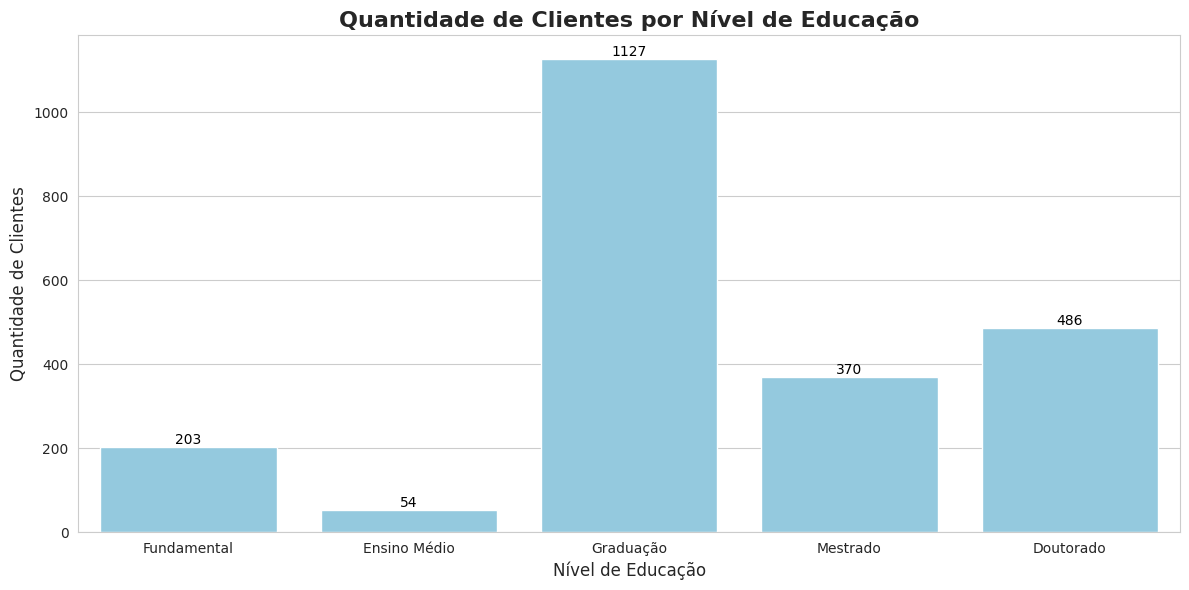

In [13]:
# Definindo a ordem das categorias
ordem_educacao = ['Fundamental', 'Ensino Médio', 'Graduação', 'Mestrado', 'Doutorado']

# Contando as ocorrências de cada categoria na variável 'NivelDeEducacao' e ordenando em ordem decrescente
funcao_counts = df_publico['NivelDeEducacao'].value_counts().reindex(ordem_educacao)

plt.figure(figsize=(12, 6))

# Plotando o gráfico de barras com seaborn e deixando o Seaborn gerenciar as cores
ax = sns.countplot(x='NivelDeEducacao', data=df_publico, order=ordem_educacao, color='skyblue')

# Adicionando os valores de cada barra
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Nível de Educação', fontsize=12)
plt.ylabel('Quantidade de Clientes', fontsize=12)
plt.title('Quantidade de Clientes por Nível de Educação', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [14]:
(df_publico['NivelDeEducacao']=='Graduação').sum()/len(df_publico)*100

np.float64(50.31250000000001)

### 2.4.4 Nível de educação X Target

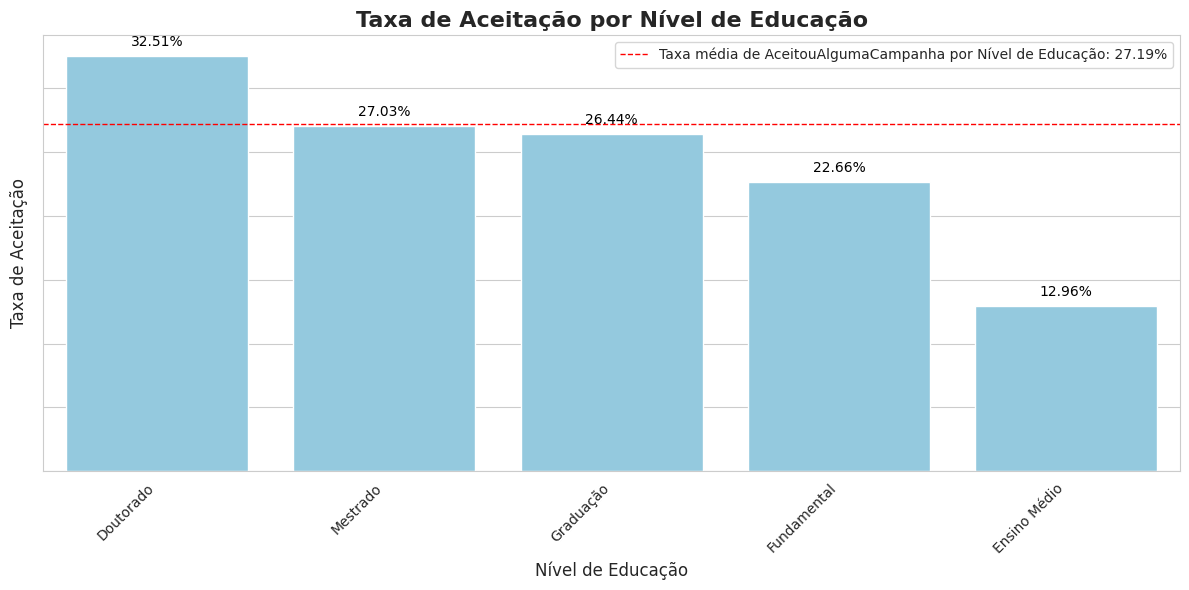

In [15]:
# Calculando a taxa de aceitacao para cada função
taxa_aceitacao_por_funcao = df_publico.groupby('NivelDeEducacao')['AceitouAlgumaCampanha'].apply(lambda x: (x == 1).mean())

# Ordenando as funções por taxa de aceitacao
funcoes_ordenadas = taxa_aceitacao_por_funcao.sort_values(ascending=False)

plt.figure(figsize=(12,6))

# Plotando o gráfico de barras com cor azul
ax = sns.barplot(x=funcoes_ordenadas.index, y=funcoes_ordenadas.values, color='skyblue')

# Adicionando os valores de cada barra
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.gca().axes.yaxis.set_ticklabels([])

# Adicionando uma linha indicando a taxa média de Aceitação
taxa_media_aceitacao_funcao = df_publico['AceitouAlgumaCampanha'].value_counts(normalize=True).get(1, 0)
plt.axhline(taxa_media_aceitacao_funcao, color='red', linestyle='dashed', linewidth=1, label='Taxa média de AceitouAlgumaCampanha por Nível de Educação: {:.2f}%'.format(taxa_media_aceitacao_funcao * 100))

plt.xlabel('Nível de Educação', fontsize=12)
plt.ylabel('Taxa de Aceitação', fontsize=12)
plt.title('Taxa de Aceitação por Nível de Educação', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos

# Adicionando a legenda
plt.legend()

plt.show()

* Clientes com graduação representam cerca de 50% da base;

* Clientes com doutorados são os únicos que possuem taxa de aceitação acima da média, com 32,51% de aceitação;

* Clientes com Ensino Médio possuem apenas 12,96% de aceitação de campanhas.

### 2.4.5 Estado civil

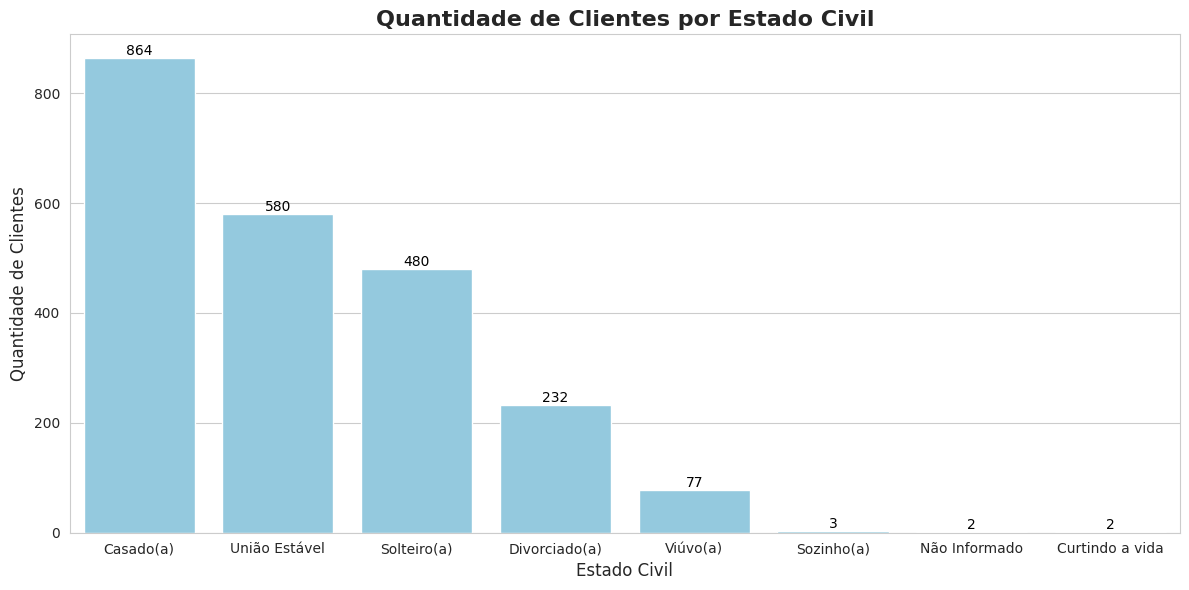

In [16]:
plt.figure(figsize=(12, 6))

order = df_publico['EstadoCivil'].value_counts().index

# Plotando o gráfico de barras com seaborn e deixando o Seaborn gerenciar as cores
ax = sns.countplot(x='EstadoCivil', data=df_publico, color='skyblue', order=order)

# Adicionando os valores de cada barra
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Estado Civil', fontsize=12)
plt.ylabel('Quantidade de Clientes', fontsize=12)
plt.title('Quantidade de Clientes por Estado Civil', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [17]:
df_publico['EstadoCivil'].value_counts(normalize=True).mul(100).round(2)

,proportion
EstadoCivil,
Casado(a),38.57
União Estável,25.89
Solteiro(a),21.43
Divorciado(a),10.36
Viúvo(a),3.44
Sozinho(a),0.13
Não Informado,0.09
Curtindo a vida,0.09


### 2.4.6 Estado civil X Target

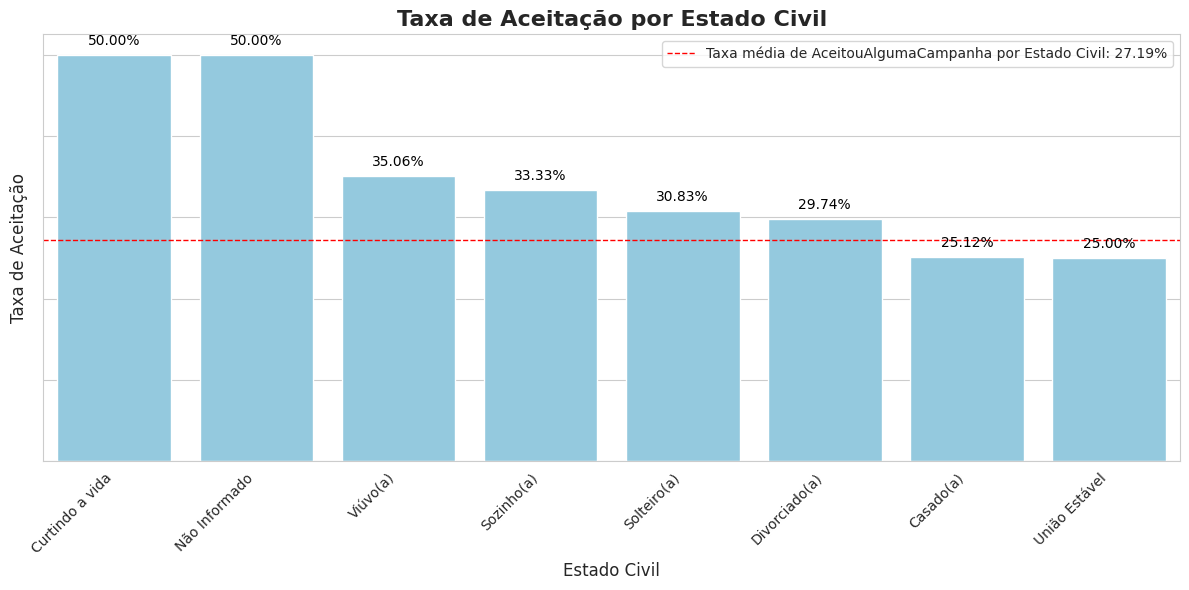

In [18]:
# Calculando a taxa de aceitacao para cada função
taxa_aceitacao_por_funcao = df_publico.groupby('EstadoCivil')['AceitouAlgumaCampanha'].apply(lambda x: (x == 1).mean())

# Ordenando as funções por taxa de aceitacao
funcoes_ordenadas = taxa_aceitacao_por_funcao.sort_values(ascending=False)

plt.figure(figsize=(12,6))

# Plotando o gráfico de barras com cor azul
ax = sns.barplot(x=funcoes_ordenadas.index, y=funcoes_ordenadas.values, color='skyblue')

# Adicionando os valores de cada barra
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.gca().axes.yaxis.set_ticklabels([])

# Adicionando uma linha indicando a taxa média de Aceitação
taxa_media_aceitacao_funcao = df_publico['AceitouAlgumaCampanha'].value_counts(normalize=True).get(1, 0)
plt.axhline(taxa_media_aceitacao_funcao, color='red', linestyle='dashed', linewidth=1, label='Taxa média de AceitouAlgumaCampanha por Estado Civil: {:.2f}%'.format(taxa_media_aceitacao_funcao * 100))

plt.xlabel('Estado Civil', fontsize=12)
plt.ylabel('Taxa de Aceitação', fontsize=12)
plt.title('Taxa de Aceitação por Estado Civil', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')  # Rotaciona os rótulos do eixo x para melhor visualização
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos

# Adicionando a legenda
plt.legend()

plt.show()

* Clientes casados ou em união estável representam quase 2/3 da base;

* Clientes "Curtindo a vida", "Não informado" e "Sozinho" tem alta taxa de aceitação, porém representam apenas 7 pessoas em todo o dataframe, então não podem ser considerados;

* Apesar de ser a grande maioria, clientes casados ou em união estável possuem uma taxa de aceitação abaixo da média, diferente de todos os outros grupos.

### 2.4.7 Quantidade de Filhos

Primeiro devemos criar uma variável para indicar se o cliente tem filhos (crianças ou adolescentes)

In [19]:
# criando a variável "QtdFilhos"
df_publico['QtdFilhos'] = df_publico['QtdDeCriancasNaCasa'] + df_publico['QtdDeAdolescentesNaCasa']

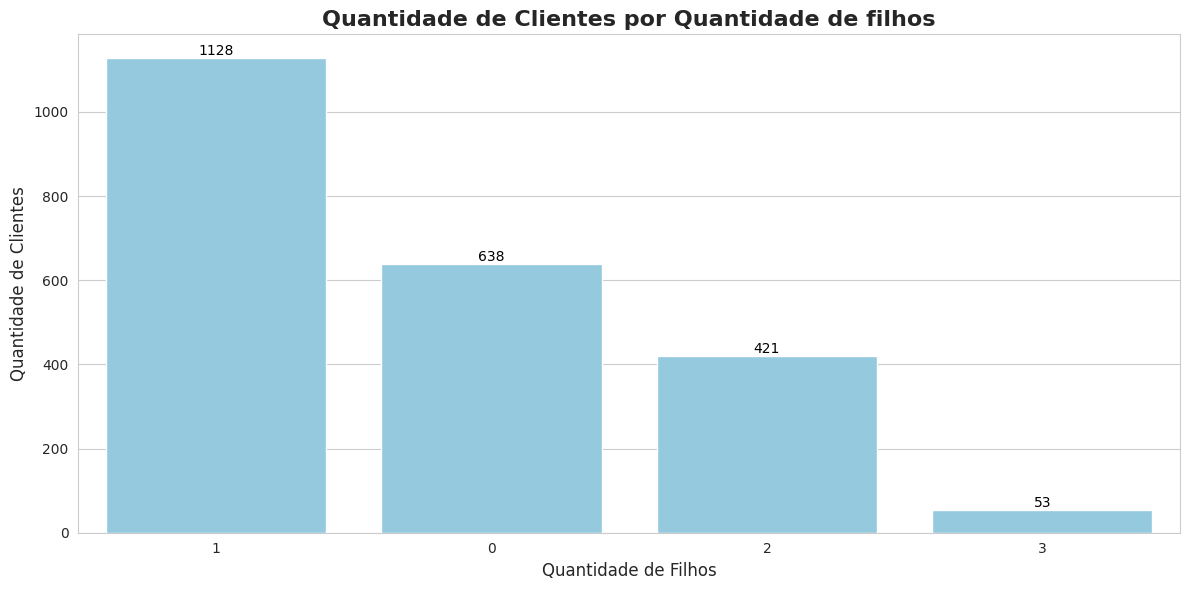

In [20]:
plt.figure(figsize=(12, 6))

order = df_publico['QtdFilhos'].value_counts().index

# Plotando o gráfico de barras com seaborn e deixando o Seaborn gerenciar as cores
ax = sns.countplot(x='QtdFilhos', data=df_publico, color='skyblue', order=order)

# Adicionando os valores de cada barra
for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Quantidade de Filhos', fontsize=12)
plt.ylabel('Quantidade de Clientes', fontsize=12)
plt.title('Quantidade de Clientes por Quantidade de filhos', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### 2.4.8 Quantidade de filhos X Target

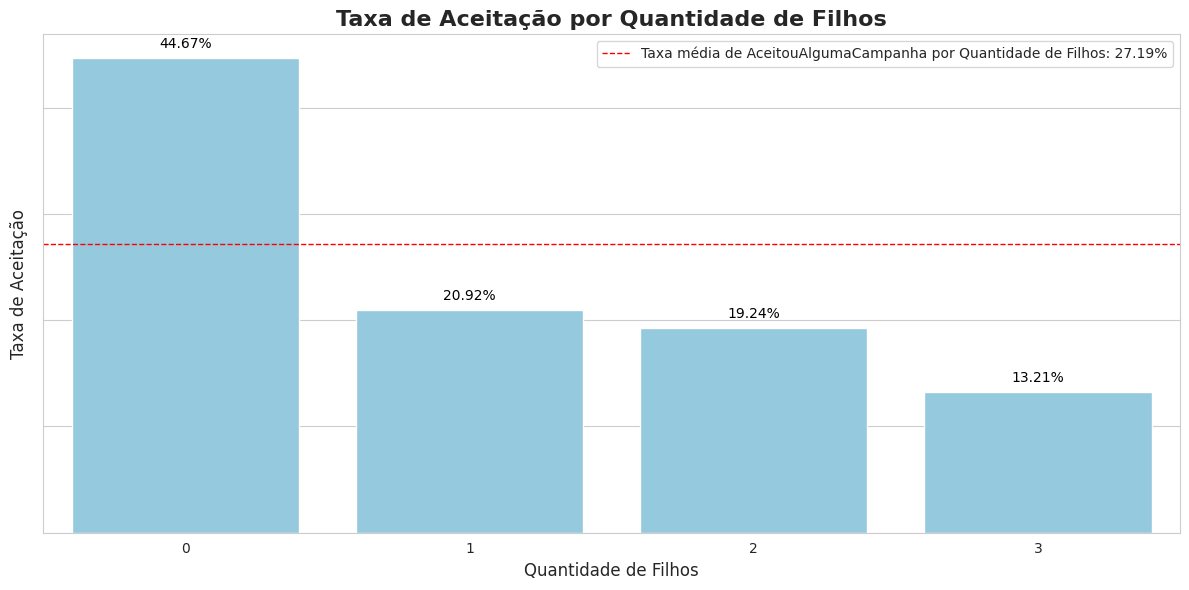

In [21]:
# Calculando a taxa de aceitacao para cada função
taxa_aceitacao_por_funcao = df_publico.groupby('QtdFilhos')['AceitouAlgumaCampanha'].apply(lambda x: (x == 1).mean())

# Ordenando as funções por taxa de aceitacao
funcoes_ordenadas = taxa_aceitacao_por_funcao.sort_values(ascending=False)

plt.figure(figsize=(12,6))

# Plotando o gráfico de barras com cor azul
ax = sns.barplot(x=funcoes_ordenadas.index, y=funcoes_ordenadas.values, color='skyblue')

# Adicionando os valores de cada barra
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height() * 100), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.gca().axes.yaxis.set_ticklabels([])

# Adicionando uma linha indicando a taxa média de Aceitação
taxa_media_aceitacao_funcao = df_publico['AceitouAlgumaCampanha'].value_counts(normalize=True).get(1, 0)
plt.axhline(taxa_media_aceitacao_funcao, color='red', linestyle='dashed', linewidth=1, label='Taxa média de AceitouAlgumaCampanha por Quantidade de Filhos: {:.2f}%'.format(taxa_media_aceitacao_funcao * 100))

plt.xlabel('Quantidade de Filhos', fontsize=12)
plt.ylabel('Taxa de Aceitação', fontsize=12)
plt.title('Taxa de Aceitação por Quantidade de Filhos', fontsize=16, fontweight='bold')
plt.tight_layout()  # Ajusta o layout para evitar sobreposição de elementos

# Adicionando a legenda
plt.legend()

plt.show()

* Pessoas que não tem filhos tendem a ter uma taxa de aceitação de campanhas maior que as demais.

* Parece que quanto mais filhos o cliente possui, menor sua taxa de aceitação.

### 2.4.9 Idade

Primeiro devemos criar a variável idade, pois possuímos apenas o ano de nascimento.

In [22]:
ano_atual = datetime.now().year
data_atual = datetime.now()

# Criando a variável 'Idade'
df_publico['Idade'] = ano_atual - df_publico['AnoDeNascimento']

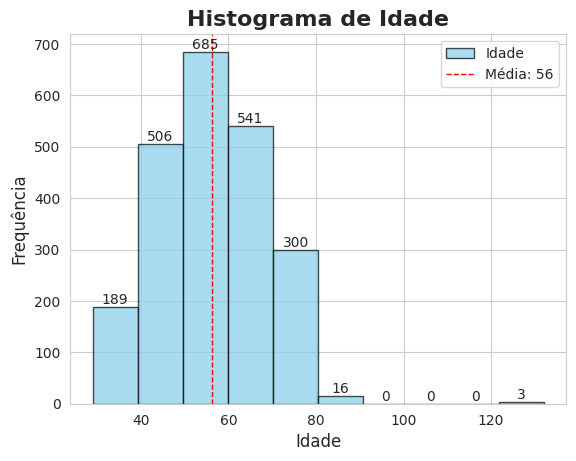

In [23]:
# Plotando o histograma das idades
hist, bins, _ = plt.hist(df_publico['Idade'], bins=10, color='skyblue', edgecolor='black', alpha=0.7, label='Idade')

# Calculando a média das idades
media_renda = df_publico['Idade'].mean()

# Adicionando a linha vertical para a média
plt.axvline(media_renda, color='red', linestyle='dashed', linewidth=1)
plt.legend(['Idade', 'Média: {:.0f}'.format(media_renda)], loc='upper right')

# Adicionando os valores da frequência em cada barra
for i in range(len(hist)):
    plt.text(bins[i] + (bins[i+1] - bins[i]) / 2, hist[i], str(int(hist[i])), ha='center', va='bottom')

# Configurando os rótulos e título
plt.xlabel('Idade', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.title('Histograma de Idade', fontsize=16, fontweight='bold')

# Mostrando o gráfico
plt.show()

### 2.4.10 Faixa de idade x Target

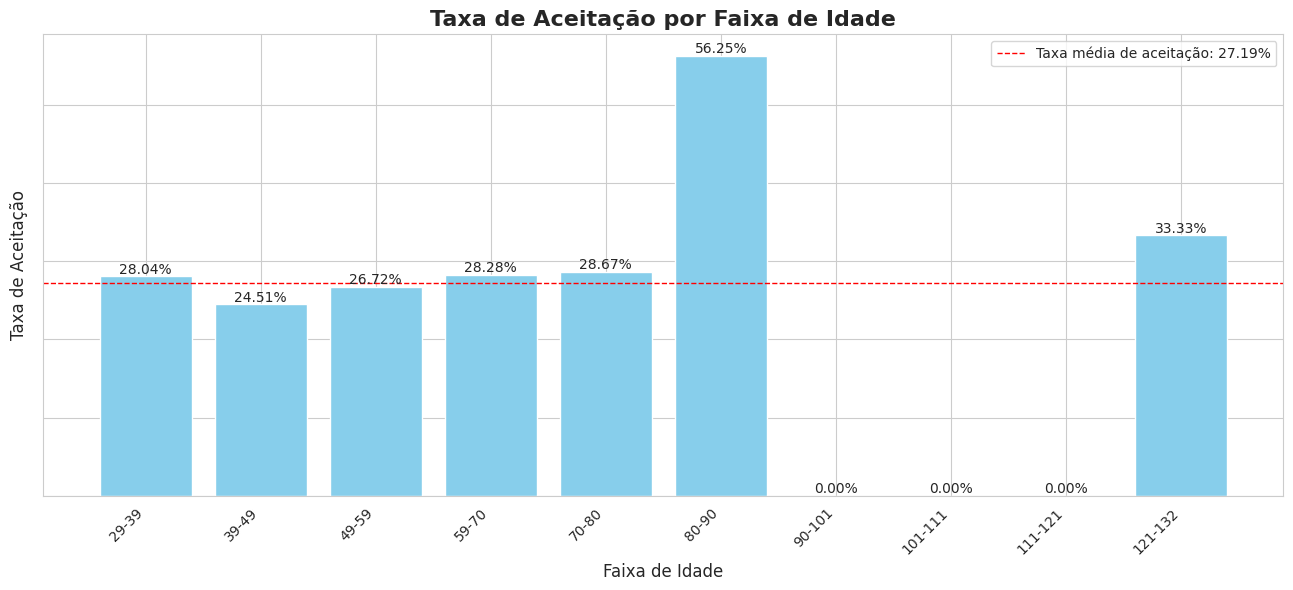

In [24]:
# criando as faixas
taxa_aceitacao_por_faixa = []
for i in range(len(bins)-1):
    faixa_inferior = bins[i]
    faixa_superior = bins[i+1]
    taxa_aceitacao = df_publico[(df_publico['Idade'] >= faixa_inferior) & (df_publico['Idade'] <= faixa_superior)]['AceitouAlgumaCampanha'].value_counts(normalize=True).get(1, 0)
    taxa_aceitacao_por_faixa.append(taxa_aceitacao)

# Calculando a média da variável de aceitacao
taxa_media_aceitacao = df_publico['AceitouAlgumaCampanha'].value_counts(normalize=True).get(1, 0)

# Plotando o gráfico de barras
plt.figure(figsize=(16,6))
plt.bar(range(len(bins)-1), taxa_aceitacao_por_faixa, color='skyblue')

# Adicionando os valores das taxas de aceitacao nas barras
for i, taxa in enumerate(taxa_aceitacao_por_faixa):
    plt.text(i, taxa, '{:.2f}%'.format(taxa * 100), ha='center', va='bottom', fontsize=10)

# Adicionando uma linha indicando a média da variável de aceitacao
plt.axhline(taxa_media_aceitacao, color='red', linestyle='dashed', linewidth=1, label='Taxa média de aceitação: {:.2f}%'.format(taxa_media_aceitacao * 100))

# Adicionando as faixas de idade no eixo x
plt.xticks(range(len(bins)-1), ['{}-{}'.format(int(faixa_inf), int(faixa_sup)) for faixa_inf, faixa_sup in zip(bins[:-1], bins[1:])], rotation=45, ha='right')

plt.gca().axes.yaxis.set_ticklabels([])

# Adicionando rótulos e título
plt.xlabel('Faixa de Idade', fontsize=12)
plt.ylabel('Taxa de Aceitação', fontsize=12)
plt.title('Taxa de Aceitação por Faixa de Idade', fontsize=16, fontweight='bold')

# Adicionando a legenda
plt.legend()

# Mostrando o gráfico
plt.show()

* Os clientes estão concentrados na média de 56 anos, porém existem clientes entre 29 e 132 anos;

* Clientes entre 80 e 90 anos pussuem cerca de 50% de taxa de aceitação, mas não existem muitos clientes nesse range de idade;

* Existem apenas 3 clientes entre 121 e 132 anos, sendo que apenas 1 deles aceitou alguma campanha.